In [1]:
import os
import gzip
import re
import tarfile

from os.path import join as pjoin
from six.moves import urllib

from tensorflow import gfile
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

%matplotlib inline

# ploting style
plt.style.use('ggplot')

_PAD = "<pad>"
_SOS = "<sos>"
_UNK = "<unk>"
_START_VOCAB = [_PAD, _SOS, _UNK]

PAD_ID = 0
SOS_ID = 1
UNK_ID = 2

In [2]:
source_dir = os.path.join(os.curdir, 'data')
sst_path = os.path.join(os.curdir, 'sst-data')
train_path = pjoin(source_dir, "train")
valid_path = pjoin(source_dir, "val")
dev_path = pjoin(source_dir, "dev")

# vocabulary
vocab_path = pjoin(source_dir, "vocab.dat")

#### load the data txt file 

In [3]:
## raw sentence
df_sentence = pd.read_csv(sst_path + 'datasetSentences.txt', sep= '\t', index_col = 0)

## split condition
df_split = pd.read_csv(sst_path + 'datasetSplit.txt', index_col= 0)

df_sentence = df_sentence.join(df_split)

df_sentence.set_index('sentence', inplace= True)

In [5]:
## sentiment
df_sentiment = pd.read_csv(sst_path + 'sentiment_labels.txt', sep = '|')
df_sentiment.columns = ["id", "sentiment"]

## phrase dictionary 
df_dicionary = pd.read_csv(sst_path + 'dictionary.txt', sep = '|', header=None)
df_dicionary.columns = ['phrase',  'id']

df_phrase = df_dicionary.set_index('id').join(df_sentiment.set_index('id'))

In [6]:
df_final = df_phrase.join(df_sentence, on = 'phrase')
df_final.dropna(inplace = True)

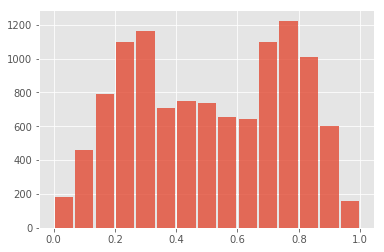

In [7]:
df_final['sentiment'].hist(bins = 15, rwidth = 0.9, alpha = 0.8)

In [14]:
df_final['label'] = pd.cut(df_final.sentiment, [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                           include_lowest=True,
                           labels=[0, 1, 2, 3, 4])

In [18]:
df_final.head()

phrase  sentiment  \
id                                                                     
102340  , The Sum of All Fears is simply a well-made a...    0.88889   
221244                       , `` They 're out there ! ''    0.61111   
221388  , is a temporal inquiry that shoulders its phi...    0.69444   
221714       - I also wanted a little alien as a friend !    0.69444   
221716  - West Coast rap wars , this modern mob music ...    0.76389   

        splitset_label label  
id                            
102340             1.0     4  
221244             1.0     3  
221388             1.0     3  
221714             1.0     3  
221716             1.0     3

* store the data 


In [23]:
store_path = os.path.join(os.curdir, 'data') 

In [31]:
# filter out the too short comment
df_final_trim = df_final[df_final['phrase'].apply(lambda text: len(text.split(' '))) > 5]

In [ ]:
df_final_trim['length'] = df_final_trim['phrase'].apply(lambda txt: len(txt.split(' ')))

In [14]:
df_final_trim.to_csv(sst_path + '/general_SST_data.csv')

In [3]:
df_final_trim = pd.read_csv(sst_path + '/general_SST_data.csv', index_col=0)

* Binary Sentiment Classification Data

In [19]:
df_SST_bina = df_final_trim[df_final_trim['label'] != 2].copy()

In [11]:
def sentiment_dist_binary(sentiment_score):
    if sentiment_score >= 0.6:
        return 1
    elif sentiment_score <= 0.4:
        return 0
    else:
        return None

In [20]:
df_SST_bina['label'] = df_SST_bina['sentiment'].apply(sentiment_dist_binary)

In [23]:
df_SST_bina.head()

phrase  sentiment  \
id                                                                     
102340  , The Sum of All Fears is simply a well-made a...    0.88889   
221244                       , `` They 're out there ! ''    0.61111   
221388  , is a temporal inquiry that shoulders its phi...    0.69444   
221714       - I also wanted a little alien as a friend !    0.69444   
221716  - West Coast rap wars , this modern mob music ...    0.76389   

        splitset_label  label  length  
id                                     
102340             1.0      1      14  
221244             1.0      1       8  
221388             1.0      1      12  
221714             1.0      1      11  
221716             1.0      1      16

In [24]:
def data_split(df_SST):
    # according to splitset_lable, divide df into {train|val|dev} 
    df_train = df_SST[df_SST['splitset_label'] == 1]
    df_val = df_SST[df_SST['splitset_label'] == 2]
    df_test = df_SST[df_SST['splitset_label'] == 3]
    
    return_feat = ['phrase', 'label']
    return df_train[return_feat], df_val[return_feat], df_test[return_feat]

In [25]:
df_train, df_val, df_test = data_split(df_SST_bina)

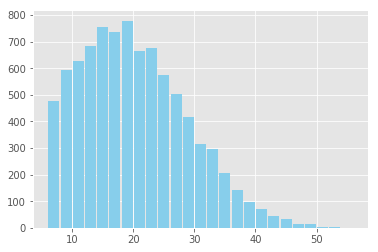

In [30]:
# display the length distribution
# pick up the maximum sequence length to be 40
df_SST_bina['length'].hist(bins = 25, rwidth = 0.9, color ='skyblue' )

In [33]:
train_path

'./data/train'

save into text

In [32]:
def save_to_text(save_path, text_data):
    with gfile.GFile(save_path, mode="w") as text_file:
        counter = 0
        for line in text_data:
            counter += 1
            text_file.write(str(line) + "\n")

In [59]:
save_to_text(train_path + '.text', df_train['phrase'])
save_to_text(train_path + '.label', df_train['label'])

In [35]:
save_to_text(valid_path + '.text', df_val['phrase'])
save_to_text(valid_path + '.label', df_val['label'])

In [36]:
save_to_text(dev_path + '.text', df_test['phrase'])
save_to_text(dev_path + '.label', df_test['label'])

* generate vocabulary vector

In [38]:
def tokenize(sequence):
    tokens = [token.replace("``", '"').replace("''", '"') for token in nltk.word_tokenize(sequence)]
    return [x for x in tokens] # .encode('utf8')

def basic_tokenizer(sentence):
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(re.split(" ", space_separated_fragment))
    return [w for w in words if w]

def create_vocabulary(vocabulary_path, text_data, tokenizer):
    '''Output'''
    if not gfile.Exists(vocabulary_path):
        print("creating vocabulary %s from data" % (vocabulary_path))
        vocab = {}
        counter = 0 # keep record of the number
        for line in tqdm(text_data):
            counter += 1
            tokens = tokenizer(line)
            for w in tokens:
                if w in vocab:
                    vocab[w] += 1
                else:
                    vocab[w] = 1
        vocab_list = _START_VOCAB + sorted(vocab, key=vocab.get, reverse=True)
        print("Vocabulary size: %d" % len(vocab_list))
        with gfile.GFile(vocabulary_path, mode="wb") as vocab_file:
            for w in vocab_list:
                vocab_file.write(w + "\n")

def initialize_vocabulary(vocabulary_path):
    '''Input'''
    # map vocab to word embeddings
    if gfile.Exists(vocabulary_path):
        rev_vocab = []
        with gfile.GFile(vocabulary_path, mode="r") as f:
            rev_vocab.extend(f.readlines())
        rev_vocab = [line.strip('\n') for line in rev_vocab]
        vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
        return vocab, rev_vocab
    else:
        raise ValueError("Vocabulary file %s not found.", vocabulary_path)

In [39]:
create_vocabulary(vocab_path, df_final_trim['phrase'], basic_tokenizer)

In [40]:
# read the vocabulary
vocab, rev_vocab = initialize_vocabulary(vocab_path)

* load GloVe

In [97]:
def generate_glove(vocab_list, save_path, glove_dir, glove_source,
                   glove_dim=300, size=3e4, random_init=True):
    """
    store the embedding matrix of specific GloVe vector 
    :param vocab_list: [vocab]
    :return:
    """
    if not gfile.Exists(save_path + ".npz"):
        if glove_source == 'wiki':
            glove_path = os.path.join(glove_dir, "glove.6B.{}d.txt".format(glove_dim))
        elif glove_source == 'crawl_cs':
            glove_path = os.path.join(glove_dir, "glove.840B.300d.txt")
            glove_dim = 300
        elif glove_source == 'crawl_ci':
            glove_path = os.path.join(glove_dir, "glove.42B.300d.txt")
            glove_dim = 300
        
        if random_init:
            glove = np.random.randn(len(vocab_list), glove_dim)
        else:
            glove = np.zeros((len(vocab_list), glove_dim))

        found = 0
        with open(glove_path, 'r', encoding='utf8') as fh:  # NOTE: encoding='utf8, new addition, may cause problems elsewhere
            for line in tqdm(fh, total=size):
                array = line.lstrip().rstrip().split(" ")
                word = array[0]
                vector = list(map(float, array[1:]))
                if word in vocab_list:
                    idx = vocab_list.index(word)
                    glove[idx, :] = vector
                    found += 1
                elif word.capitalize() in vocab_list:
                    idx = vocab_list.index(word.capitalize())
                    glove[idx, :] = vector
                    found += 1
                elif word.lower() in vocab_list:
                    idx = vocab_list.index(word.lower())
                    glove[idx, :] = vector
                    found += 1
                elif word.upper() in vocab_list:
                    idx = vocab_list.index(word.upper())
                    glove[idx, :] = vector
                    found += 1

        print("{}/{} of word vocab have corresponding vectors in {}".format(found, len(vocab_list), glove_path))
        np.savez_compressed(save_path, glove=glove)
        print("saved trimmed glove matrix at: {}".format(save_path))

In [98]:
generate_glove(rev_vocab, source_dir + "/glove.trimmed.300", source_dir, 'wiki')

400000it [07:09, 932.11it/s]                             


16986/20656 of word vocab have corresponding vectors in ./data/glove.6B.300d.txt
saved trimmed glove matrix at: ./data/glove.trimmed.300


* create the {train | dev | val} token id dataset

In [41]:
def basic_tokenizer(sentence):
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(re.split(" ", space_separated_fragment.decode('utf-8')))
    return [w for w in words if w]

def sentence_to_token_ids(sentence, vocabulary, tokenizer):
    words = tokenizer(sentence)
    return [vocabulary.get(w, UNK_ID) for w in words]

def data_to_token_ids(data_path, target_path, vocabulary_path, tokenizer):
    if not gfile.Exists(target_path):
        print("Tokenizing data in %s" % data_path)
        vocab, _ = initialize_vocabulary(vocabulary_path)
        with gfile.GFile(data_path, mode="rb") as data_file:
            with gfile.GFile(target_path, mode="w") as tokens_file:
                counter = 0
                for line in data_file:
                    counter += 1
                    if counter % 5000 == 0:
                        print("tokenizing line %d" % counter)
                    token_ids = sentence_to_token_ids(line, vocab, tokenizer)
                    tokens_file.write(" ".join([str(tok) for tok in token_ids]) + "\n")
                    

In [48]:
x_train_ids_path = train_path + ".ids.text"
data_to_token_ids(pjoin(train_path,'text'), x_train_ids_path, vocab_path, basic_tokenizer)

x_val_ids_path = valid_path + ".ids.text"
data_to_token_ids(pjoin(valid_path,'text'), x_val_ids_path, vocab_path, basic_tokenizer)

x_dev_ids_path = dev_path + ".ids.text"
data_to_token_ids(pjoin(dev_path,"text"), x_dev_ids_path, vocab_path, basic_tokenizer)

* Demo of DataPipeline Object

read the data and automatically generate the batch

In [49]:
from utils.datatool import get_data_paths
from dataset import DataPipeline

In [50]:
train_dt = DataPipeline(*get_data_paths(source_dir, name='train'), 30)

output format:

input_text | input_length | true_label

In [55]:
input_text, input_length, true_label = train_dt.get_batch(12)

In [56]:
print('Sample Tokenized of length {} with true label {}'.format(input_length[1], true_label[1]))

print(input_text[1])

Sample Tokenized of length 15 with true label 0
[1614, 1596, 5, 16838, 105, 29, 367, 5, 4121, 1010, 1614, 54, 6, 9741, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
